In [2]:
import wandb
from wandb.keras import WandbCallback

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Input, concatenate, Conv2D, Activation, ZeroPadding2D, UpSampling2D, add
from tensorflow.keras.models import *
from qkeras import *

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tqdm import tqdm

In [5]:
PRETRAINED = True
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2023-09-03 22:04:44.152697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-03 22:04:44.152738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cmsgpu01.hep.wisc.edu
2023-09-03 22:04:44.152748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cmsgpu01.hep.wisc.edu
2023-09-03 22:04:44.152848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-09-03 22:04:44.152893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-09-03 22:04:44.152903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


### Data Processing

In [6]:
def generate_border(image, border_size=1, n_erosions=1):
    
    image = np.array(image*255.0, dtype = np.uint8)
    erosion_kernel = np.ones((1,1), np.uint8)      ## Start by eroding edge pixels
    eroded_image = cv2.erode(image, erosion_kernel, iterations=n_erosions)  
 
    ## Define the kernel size for dilation based on the desired border size (Add 1 to keep it odd)
    kernel_size = 2*border_size + 1 
    dilation_kernel = np.ones((kernel_size, kernel_size), np.uint8)   #Kernel to be used for dilation
    dilated  = cv2.dilate(eroded_image, dilation_kernel, iterations = 1)
    
    ## Replace 255 values to 127 for all pixels. Eventually we will only define border pixels with this value
    dilated_127 = np.where(dilated == 255, 3, dilated)
    original_with_border = np.where(eroded_image > 127, 1, dilated_127)
    original_with_border = np.where(original_with_border == 0, 2, original_with_border)
    
    return original_with_border

In [9]:
data = np.load("/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/EMData-20230709.npy")

In [10]:
data = data.swapaxes(1,2)
data = data.reshape(data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4])

In [11]:
## Many examples (~30%) seem to be part of the empty array space; Removing extra sample

In [12]:
empty_examples = np.where(np.sum(data, axis=(1,2,3))==0.0)[0]
#drop_list  = np.random.choice(empty_examples, size=empty_examples.shape[0])
drop_list = empty_examples
data = np.delete(data, drop_list, axis=0)
data = np.expand_dims(data, axis=-1)
data.shape

(57495, 2, 10, 10, 1)

In [13]:
# processing masks for trimaps
trimaps = np.array([generate_border(mask) for mask in data[:,1]])
trimaps = np.expand_dims(trimaps, axis=-1)

[15766 44178 53664   987]


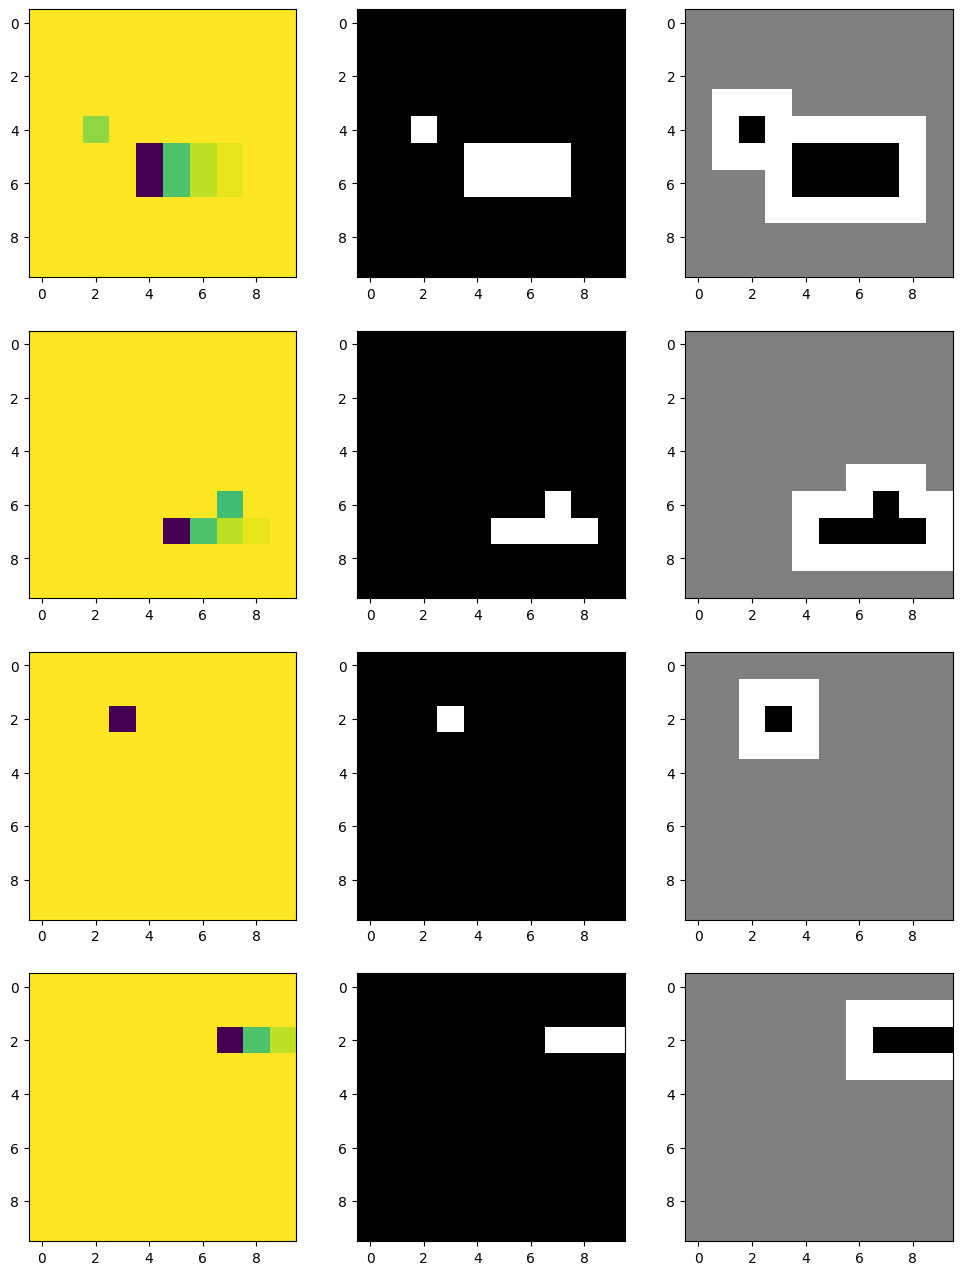

In [14]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(data)-1, size=(num_example_to_display,))
#sample_idxs = [0, 1, 2, 3]
print(sample_idxs)

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
    img = data[sample_idx][0]
    mask = data[sample_idx][1]
    trimap = trimaps[sample_idx]
    #print(np.unique(mask), np.unique((1-mask)*255.))
    axs[i][0].imshow(1-img)
    axs[i][1].imshow(mask, cmap='gray')
    axs[i][2].imshow(trimap, cmap='gray')

In [15]:
IMG_SHAPE = 32

def normalize(image, mask):
    image = tf.cast(image / tf.reduce_max(image), tf.float32)
    mask -= 1
    return image, tf.cast(mask, tf.float32)

def load_and_preprocess(img, mask):
    img, mask = normalize(img, mask)
    return img, mask

In [16]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

input_data = data[:, 0]
mc_truth = trimaps

input_imgs, annotation_imgs = shuffle(input_data, mc_truth, random_state=42)
input_imgs_train, annotation_imgs_train = input_imgs[: -12000], annotation_imgs[: -12000]
input_imgs_test, annotation_imgs_test = input_imgs[-12000:-6000], annotation_imgs[-12000:-6000]

trainloader = tf.data.Dataset.from_tensor_slices((input_imgs_train, annotation_imgs_train))
testloader = tf.data.Dataset.from_tensor_slices((input_imgs_test, annotation_imgs_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [17]:
input_imgs_test, annotation_imgs_test = input_imgs[-6000:], annotation_imgs[-6000:]
maintestloader = tf.data.Dataset.from_tensor_slices((input_imgs_test, annotation_imgs_test))

maintestloader = (
    maintestloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2023-09-03 22:05:12.097482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [45495,10,10,1]
	 [[{{node Placeholder/_0}}]]
2023-09-03 22:05:12.097949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [45495,10,10,1]
	 [[{{node Placeholder/_0}}]]


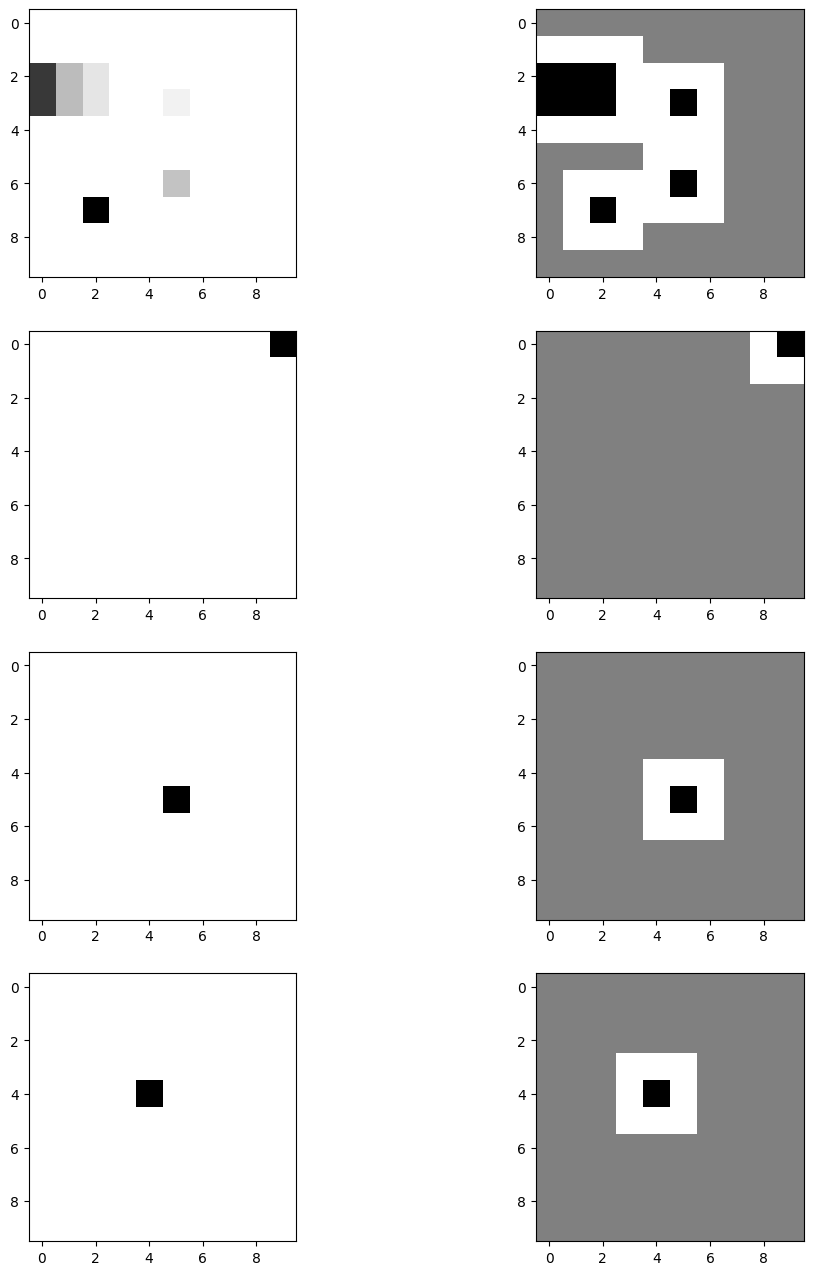

In [18]:
num_example_to_display = 4

img, mask = next(iter(trainloader))

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
    axs[i][0].imshow(1 - img[i], cmap='gray');
    axs[i][1].imshow(mask[i], cmap='gray');

In [19]:
img[i].shape, mask[i].shape

(TensorShape([10, 10, 1]), TensorShape([10, 10, 1]))

In [20]:
np.unique(mask[i])

array([0., 1., 2.], dtype=float32)

### Modeling

In [18]:
# ref: https://github.com/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb
class SegmentationModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [19]:
class UNETLiteModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool2) 

        conv5, up6 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', pool3, conv3)
        conv6, up7 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv2)
        conv7, up8 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv1)

        conv8 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', up8, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv8)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [20]:
class UNETLiteV2Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', pool1)
        
        conv5, up6 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', pool2, conv2)
        conv6, up7 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv1)

        conv7 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', up7, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv7)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [21]:
class UNETLiteV3Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', pool1)
        
        conv5, up6 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', pool2, conv2)
        conv6, up7 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv1)

        conv7 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up7, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv7)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [22]:
class UNETLiteV4Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, up3 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', pool1, conv1)

        conv4 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up3, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv4)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [23]:
IMG_SHAPE = 32

class EnetModel:
    '''
    Build ENET based model for segmentation task.
    Built for FPGA 240x152 implementation
    '''
  
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = Conv2D(filters=f3, kernel_size=(1, 1))(encode2)
        encode3 = BatchNormalization()(encode3)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # NOTE: unlike paper we do symmetrical padding (1 around)
        padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
        conv_i = Conv2D(filters=filters, kernel_size=kernel_size)(padded_pool)
        conv_i = BatchNormalization()(conv_i)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

        out = Conv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # main branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
        conv_1 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        conv_1 = BatchNormalization()(conv_1)

        x_1 = Activation("relu")(conv_1)

        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
        conv_2 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        conv_3 = Conv2D(filters=filters_o, kernel_size=(1,1))(x_2)
        conv_3 = BatchNormalization()(conv_3)

        # skip branch
        conv_4 = Conv2D(filters=filters_o, kernel_size=(1,1))(pool_1)
        conv_4 = BatchNormalization()(conv_4)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = Conv2D(filters=filters_o, kernel_size=(1,1))(connecting_layer)
        conv_1 = BatchNormalization()(conv_1)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
        conv_2 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)
        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

        conv_3 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        conv_3 = BatchNormalization()(conv_3)

        x_3 = Activation("relu")(conv_3)

        conv_4 = Conv2D(filters=filters_o, kernel_size=(1, 1))(x_3)
        conv_4 = BatchNormalization()(conv_4)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

In [24]:
class QEnetModel:
    '''
      Build ENET based model for segmentation task.
      Built for FPGA 240x152 implementation
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = QConv2DBatchnorm(filters=f3, kernel_size=(1, 1))(encode2)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # NOTE: unlike paper we do symmetrical padding (1 around)
        padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
        conv_i = QConv2DBatchnorm(filters=filters, kernel_size=kernel_size)(padded_pool)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

        out = QConv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # main branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
        conv_1 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        x_1 = Activation("relu")(conv_1)

        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
        conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        x_2 = Activation("relu")(conv_2)

        conv_3 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(x_2)

        # skip branch
        conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(pool_1)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(connecting_layer)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
        conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)
        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

        conv_3 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        x_3 = Activation("relu")(conv_3)

        conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1, 1))(x_3)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

In [25]:
class HEPAEModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        encoding_dim = 8 # 4x Compression
        
        inputs = Input(input_size)
        encoded = Dense(encoding_dim, activation='relu')(inputs)
        decoded = Dense(32, activation='softmax')(encoded)

        return Model(inputs=[inputs], outputs=[decoded])

In [26]:
class HEPCONVModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):        
        inputs = Input(input_size)
        
        x = Conv2D(10, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(5, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(5, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional
        ## Add CNN-->DNN here

        x = Conv2D(5, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(5, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(10, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(x)

        return Model(inputs=[inputs], outputs=[decoded])

In [27]:
class UNETLiteV5Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(10,10,1)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, up3 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', pool1, conv1)

        conv4 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up3, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv4)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [28]:
class UNETLiteV6Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(10,10,1)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(3, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, up3 = self.__UpConvBlock(4, 4, (3,3), (2,2), (2,2), 'relu', 'same', pool1, conv1)

        conv4 = self.__ConvBlock(3, (3,3), (2,2), 'relu', 'same', up3, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv4)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = UpSampling2D((2,2))(conv)
        up = Conv2D(up_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(up)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [120]:
class HEPCONVModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):        
        inputs = Input(input_size)
        
        x = Conv2D(2, (4, 4), activation='relu', padding='same')(inputs)
        encoded = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(2, (4, 4), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(x)

        return Model(inputs=[inputs], outputs=[decoded])

In [121]:
# output channel is 3 because we have three classes in our mask
OUTPUT_CHANNEL = 3

tf.keras.backend.clear_session()
model = HEPCONVModel().prepare_model(OUTPUT_CHANNEL, input_size=(10, 10, 1))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 2)         34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 2)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 2)           66        
                                                                 
 up_sampling2d (UpSampling2D  (None, 10, 10, 2)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 3)         57    

In [122]:
segmentation_classes = ['cluster', 'cluster_outline', 'background']

# returns a dictionary of labels
def labels():
    l = {}
    for i, label in enumerate(segmentation_classes):
        l[i] = label
    return l

# util function for generating interactive image mask from components
def wandb_mask(bg_img, pred_mask, true_mask):
    return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : labels()
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : labels()
      }
    }
  )

In [123]:
class SemanticLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(SemanticLogger, self).__init__()
        self.val_images, self.val_masks = next(iter(testloader))

    def on_epoch_end(self, logs, epoch):
        pred_masks = self.model.predict(self.val_images)
        pred_masks = np.argmax(pred_masks, axis=-1)

        val_images = tf.image.convert_image_dtype(self.val_images, tf.uint8)
        val_masks = tf.image.convert_image_dtype(self.val_masks, tf.uint8)
        val_masks = tf.squeeze(val_masks, axis=-1)
        
        pred_masks = tf.image.convert_image_dtype(pred_masks, tf.uint8)

        mask_list = []
        for i in range(len(self.val_images)):
            mask_list.append(wandb_mask(val_images[i].numpy(), 
                                      pred_masks[i].numpy(), 
                                      val_masks[i].numpy()))

        wandb.log({"predictions" : mask_list})

In [126]:
wandb.init(project='dnnae-cluster-segmentation', reinit=True)

model.fit(trainloader, 
              epochs=25,
              validation_data=testloader,
              callbacks=[WandbCallback(),
                         SemanticLogger()])

wandb.finish()

Epoch 1/25
1422/1422 [==============================] - ETA: 0s - loss: 0.0976

2023-08-27 10:25:30.504123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:25:30.685063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0976 - val_loss: 0.0951
Epoch 2/25
1417/1422 [============================>.] - ETA: 0s - loss: 0.0975

2023-08-27 10:25:40.480724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:25:40.659366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0975 - val_loss: 0.0945
Epoch 3/25
1413/1422 [============================>.] - ETA: 0s - loss: 0.0974

2023-08-27 10:25:50.358708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:25:50.537484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0974 - val_loss: 0.0945
Epoch 4/25
1420/1422 [============================>.] - ETA: 0s - loss: 0.0971

2023-08-27 10:26:00.575841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:26:00.755767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0971 - val_loss: 0.0942
Epoch 5/25
1420/1422 [============================>.] - ETA: 0s - loss: 0.0970

2023-08-27 10:26:10.469700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:26:10.649783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0970 - val_loss: 0.0938
Epoch 6/25
1415/1422 [============================>.] - ETA: 0s - loss: 0.0969

2023-08-27 10:26:20.285069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:26:20.464047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0969 - val_loss: 0.0938
Epoch 7/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0968 - val_loss: 0.0946
Epoch 8/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0965 - val_loss: 0.0943
Epoch 9/25
1418/1422 [============================>.] - ETA: 0s - loss: 0.0965

2023-08-27 10:26:48.876978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:26:49.055499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0965 - val_loss: 0.0933
Epoch 10/25
1422/1422 [==============================] - 9s 6ms/step - loss: 0.0963 - val_loss: 0.0935
Epoch 11/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0962 - val_loss: 0.0938
Epoch 12/25
1415/1422 [============================>.] - ETA: 0s - loss: 0.0962

2023-08-27 10:27:17.315472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:27:17.494737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0962 - val_loss: 0.0933
Epoch 13/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0961 - val_loss: 0.0939
Epoch 14/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0959 - val_loss: 0.0937
Epoch 15/25
1422/1422 [==============================] - 9s 6ms/step - loss: 0.0959 - val_loss: 0.0934
Epoch 16/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0959 - val_loss: 0.0934
Epoch 17/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0957 - val_loss: 0.0948
Epoch 18/25
1421/1422 [============================>.] - ETA: 0s - loss: 0.0956

2023-08-27 10:28:13.713309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:28:13.891586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.1s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0956 - val_loss: 0.0930
Epoch 19/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0955 - val_loss: 0.0940
Epoch 20/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0956 - val_loss: 0.0941
Epoch 21/25
1420/1422 [============================>.] - ETA: 0s - loss: 0.0953

2023-08-27 10:28:42.723814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:28:42.904102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0953 - val_loss: 0.0929
Epoch 22/25
1420/1422 [============================>.] - ETA: 0s - loss: 0.0952

2023-08-27 10:28:52.753645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:28:52.932937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0952 - val_loss: 0.0926
Epoch 23/25
1417/1422 [============================>.] - ETA: 0s - loss: 0.0953

2023-08-27 10:29:02.593371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-27 10:29:02.776266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_102520-k1jv0o6v/files/model-best)... Done. 0.0s


1422/1422 [==============================] - 10s 7ms/step - loss: 0.0953 - val_loss: 0.0923
Epoch 24/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0952 - val_loss: 0.0928
Epoch 25/25
1422/1422 [==============================] - 9s 7ms/step - loss: 0.0951 - val_loss: 0.0923


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_loss,█▇▇▆▅▅▇▆▄▄▅▄▅▅▄▄▇▃▅▆▃▂▁▂▁
best_epoch,22
best_val_loss,0.09226
epoch,24
loss,0.09513
val_loss,0.09235


### Prediction & Analysis

In [21]:
from keras.models import load_model

Model_logs = {"UNET":["run-20230510_173235-nm8mu5e4"],
              "ENET": ["run-20230226_175518-8y9uyk1u"], 
             "UNETv2LITE": ["run-20230227_185529-sjhgebn1"],
              "UNETv3LITE": ["run-20230303_140554-80pvvkn4"], # model1
              "UNETv4LITE": ["run-20230308_112406-8zhdka9h"], # model2
             "HEPAENET":["run-20230227_181304-zog286i7"],
             "HEPCONVNET": ["run-20230227_184034-2315xvt8"],
             "UNETv5LITE":["run-20230711_144156-d0m662qq"],
             "UNETv6LITE":["run-20230719_183445-vpng0hra", "run-20230723_202540-2cjprw0q"],
              
             "CNN299":["run-20230827_095927-qiut2tr0"],
             "CNN157":["run-20230827_102010-ygc0z81i", "run-20230827_102520-k1jv0o6v"]}


if PRETRAINED == True:
    MODEL_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230827_095927-qiut2tr0/files/model-best.h5"
    model = load_model(MODEL_PATH)

In [22]:
val_img, val_mask = next(iter(testloader))

2023-09-03 22:05:24.059290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [6000,10,10,1]
	 [[{{node Placeholder/_1}}]]
2023-09-03 22:05:24.059887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [6000,10,10,1]
	 [[{{node Placeholder/_1}}]]


In [23]:
pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

1/1 [==============================] - 0s 98ms/step


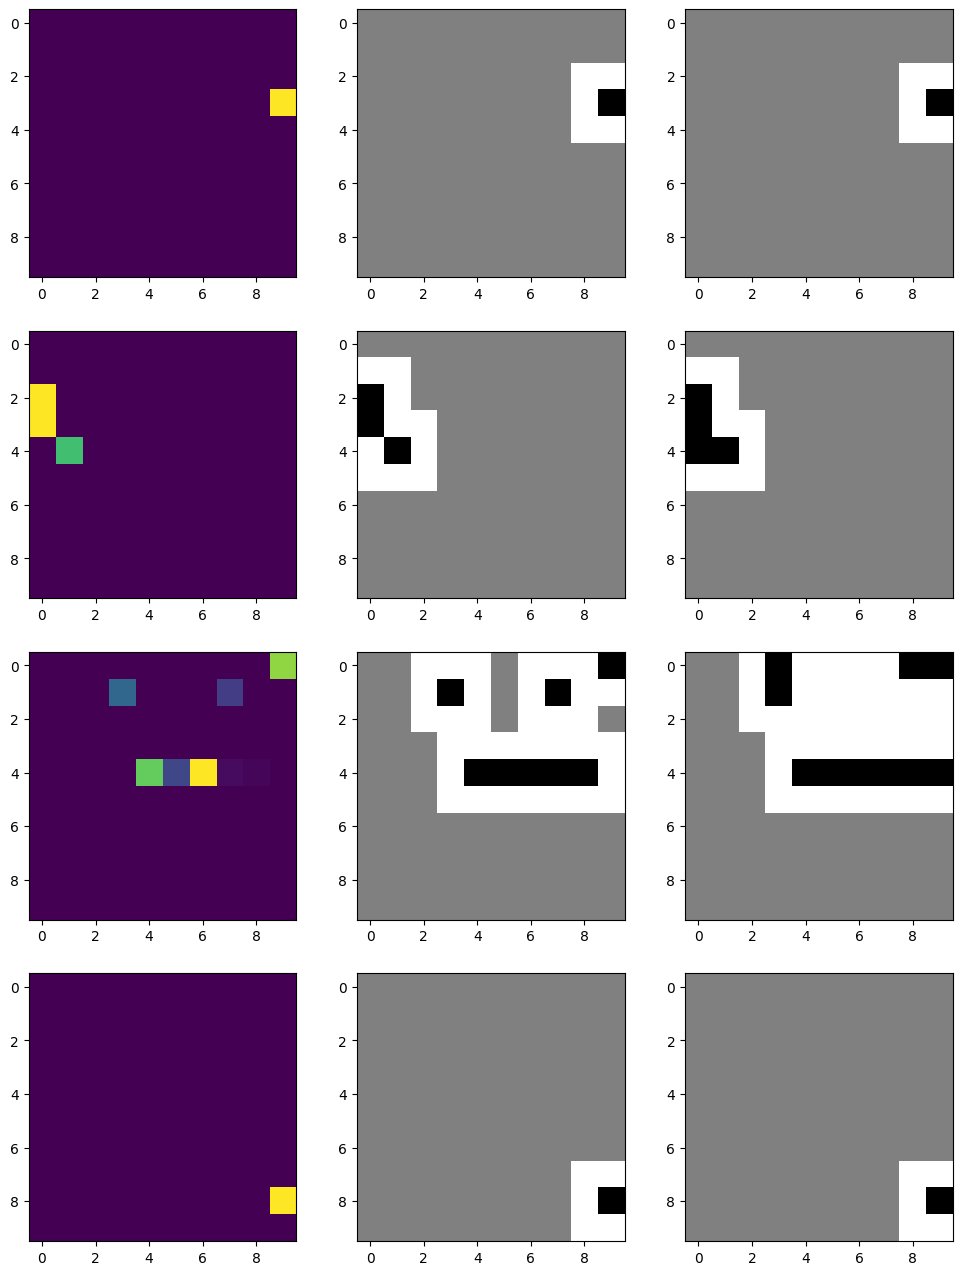

In [24]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

### T2: Instance Detection

In [25]:
import cv2

In [26]:
val_mask = np.array(val_mask)
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

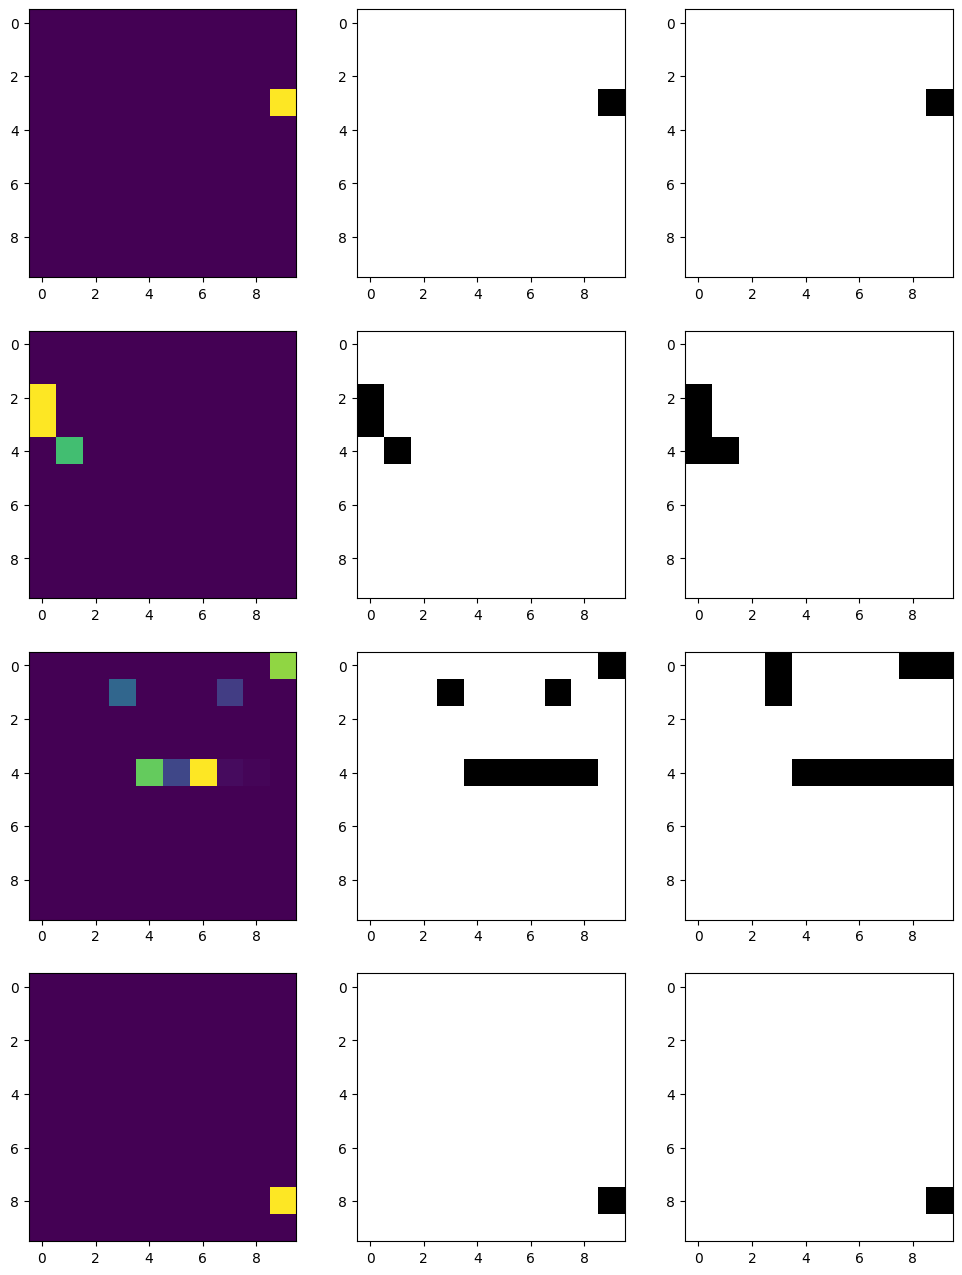

In [27]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray')
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

In [28]:
def ccl_generator(pred, mc_truth):
    test_image = np.squeeze(pred).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_pred = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_pred, labels_pred, stats_pred, centroids) = output_pred

    test_image = np.squeeze(mc_truth).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_mc = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_mc, labels_mc, stats_mc, centroids) = output_mc

    return labels_pred, labels_mc

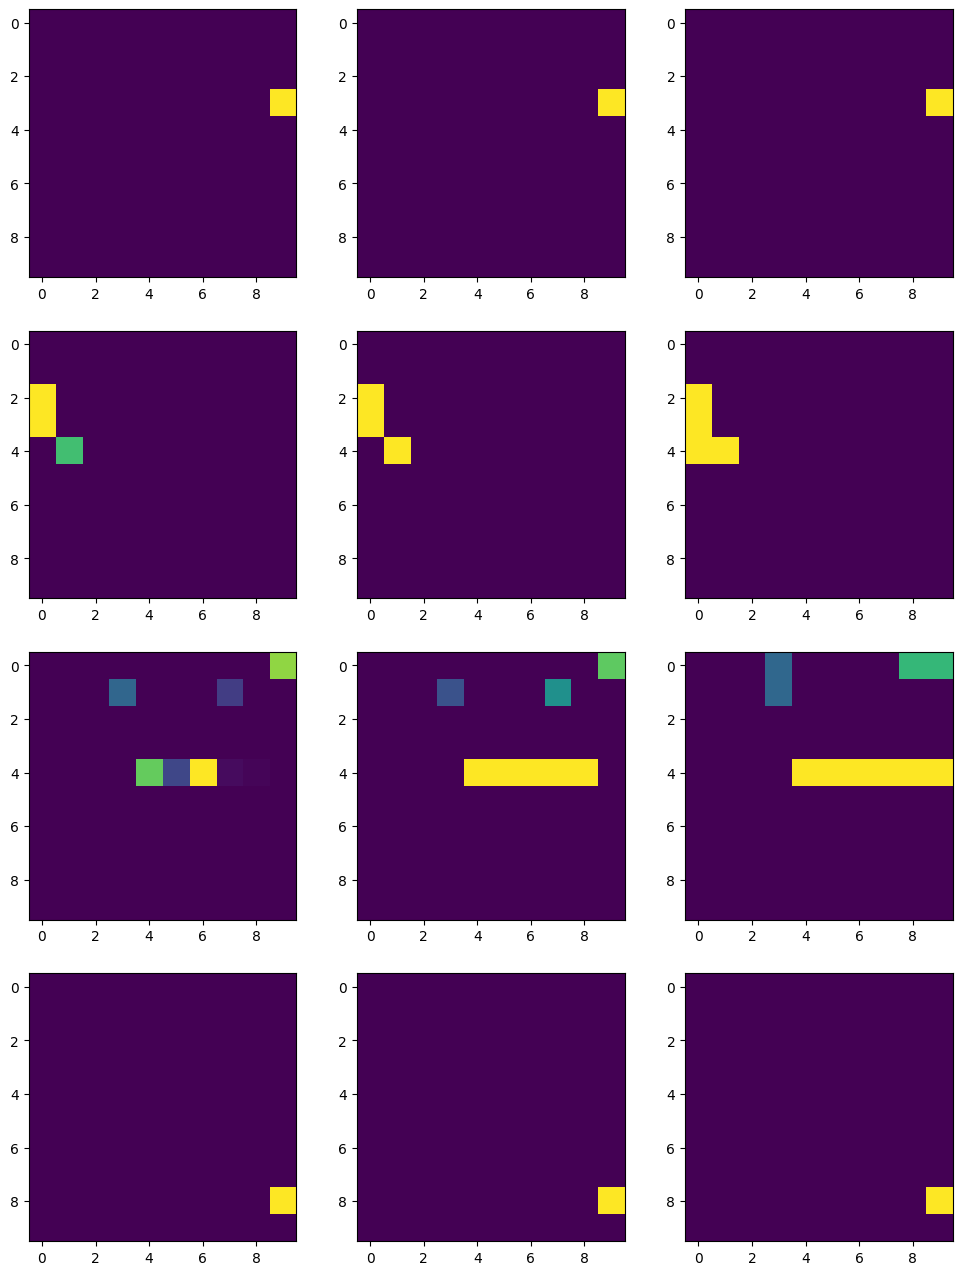

In [29]:
num_example_to_display = 4
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(lmc)
  axs[i][2].imshow(lpred)

## Testing

#### Helper Code

In [30]:
from collections import Counter

def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [31]:
"""
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image
"""

def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    # Background Matching
    u, c = np.unique(mc_truth, return_counts=True)
    bkg_label_mc = u[np.argmax(c)]
    
    u, c = np.unique(segmented_image, return_counts=True)
    bkg_label_algo = u[np.argmax(c)]
    
    hm[bkg_label_mc] = bkg_label_algo
    
    for curr_label in all_labels:
        if curr_label == bkg_label_mc:
            continue
            
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        u, c = np.unique(selected_ROI, return_counts=True)
        count_map = [x for x in zip(u,c) if x[0]!=bkg_label_algo]
        # max_overlap_index
        hm[curr_label] = max(count_map, key=lambda x:x[1])[0]
    
    # unmapped_labels
    unmapped = []
    for old_label in np.unique(segmented_image):
        if old_label not in hm.values():
            unmapped.append(old_label)
    
    uhm = {}
    max_mc_label = max(max(hm.keys()), max(hm.values()))+1
    for ol in unmapped:
        uhm[max_mc_label] = ol
        max_mc_label+=1
    
    # start mapping old_labels to mc_labels
    for label in uhm:
        mp = np.where(segmented_image==uhm[label])
        segmented_image[mp] = label
    
    for label in hm:
        mp = np.where(segmented_image==hm[label])
        segmented_image[mp] = label
    
    return segmented_image

In [32]:
def test(predicted, mc_truth, energy_snap):
    thresh = 2
    y_pred = []
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        matched, rel_energy = False, -1
        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)

        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])

        if len(ROI_algo[0]) == 0:
            matched = (False, "False Negative")
            rel_energy = 1
        
        # Might need to rewrite as a reverse loop check (loop over predicted)
        elif len(ROI_mc[0]) == 0 and len(ROI_algo[0]) !=0:
            matched = (False, "False Positive")
            rel_energy = 1

        else:
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

            if eta_res < thresh and phi_res < thresh:
                matched = True
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1

        # collecting testing data
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    return y_pred, energy_dist

In [33]:
def new_test(predicted, mc_truth, energy_snap):
    thresh, y_pred, energy_dist, fposi = 2, [], [], 0
    
    for label in np.unique(mc_truth):
        matched, rel_energy = False, -1
        if label == 0.0:
            continue
        
        # Select MC Region given label
        ROI_mc = np.where(mc_truth==label)
        ROI_predicted = predicted[ROI_mc]
        
        # inspect labels in the ROI_Predicted_region and select max
        u, c = np.unique(ROI_predicted, return_counts=True)
        count_map = [x for x in zip(u,c)]
        count_map = sorted(count_map, key=lambda x:x[1])
        
        # false negatives
        if count_map[-1][0] == 0.0:
            # false_negative
            matched = (False, "No Overlap")
            rel_energy = 1
        else:
            active_label = count_map[-1][0]
            ROI_algo = np.where(predicted==active_label)
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)
            
            if eta_res < thresh and phi_res < thresh:
                matched = True
                E_mc = np.sum(energy_snap[ROI_mc])
                E_algo = np.sum(energy_snap[ROI_algo])
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1
            
            #set active label to zero
            predicted[ROI_algo] = 0.0
        
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    u, c = np.unique(ROI_predicted, return_counts=True)
    fposi = len(u)-1
    
    return y_pred, energy_dist, fposi

#### Main run

In [34]:
val_img, val_mask, pred_mask = [], [], []
for _ in range(150):
    val_img_i, val_mask_i = next(iter(maintestloader))
    pred_mask_i = model.predict(val_img_i)
    pred_mask_i = np.argmax(pred_mask_i, axis=-1)
    pred_mask_i = np.expand_dims(pred_mask_i, axis=-1)

    val_img.extend(val_img_i)
    val_mask.extend(val_mask_i)
    pred_mask.extend(pred_mask_i)

1/1 [==============================] - 0s 24ms/step


2023-09-03 22:05:39.750278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [6000,10,10,1]
	 [[{{node Placeholder/_1}}]]
2023-09-03 22:05:39.750787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [6000,10,10,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 21ms/step


In [35]:
val_img = np.array(val_img)
val_mask = np.array(val_mask)
pred_mask = np.array(pred_mask)

In [36]:
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

In [37]:
val_img.shape, val_mask.shape, pred_mask.shape

((4800, 10, 10, 1), (4800, 10, 10, 1), (4800, 10, 10, 1))

In [38]:
all_matched, all_rel_energy, fposi, sn = [], [], 0, 0
for i in range(len(val_img)):
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
        matched, rel_energy, fposi_sub = new_test(lpred, lmc, energy_snap)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
        fposi+=fposi_sub
        
    except Exception as e:
        raise e
        print("Error in ", i)
        pass

Text(0.5, 0, 'normalized energy difference')

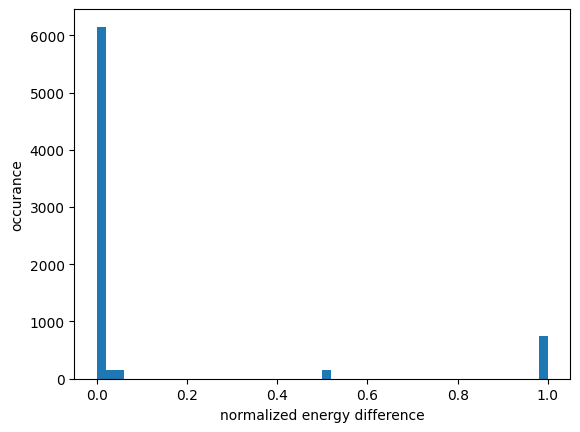

In [39]:
sub_rel = [i for i in all_rel_energy if i<=1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

In [40]:
matches = len([x for x in all_matched if x==True])
print("Correct Matches: ", matches)
print("Incorrect Matched: ", len(all_matched) - matches)

Correct Matches:  6600
Incorrect Matched:  750


In [41]:
unmatched = [x[1] for x in all_matched if type(x)==tuple]

In [42]:
unmatched

['No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overlap',
 'No Overl

In [43]:
threshold_mismatch = len([x for x in unmatched if x=='Very Low Overlap'])
print("Threshold Mismatch: ", threshold_mismatch)

fneg = len([x for x in unmatched if x=='False Negative'])
print("False Negative: ", fneg)

fposi = len([x for x in unmatched if x=='False Positive'])
print("False Positive: ", fposi)

Threshold Mismatch:  0
False Negative:  0
False Positive:  0


### Rough Notepad:

**for UNETLiteV3 ~ 7k params**

Correct Matches:  6840
Incorrect Matched:  1260
Threshold Mismatch:  330
False Negative:  930
False Positive:  0

**for UNETLiteV3 ~ 1k params**

Correct Matches:  5910
Incorrect Matched:  2190
Threshold Mismatch:  570
False Negative:  1620
False Positive:  0

trade off begins...

## Granular Testing

In [223]:
def cluster_energy_map(predicted, mc_truth, energy_snap):
    # forms tuple with format [(Energy MC Cluster, Energy Predicted Cluster)....]
    thresh = 2
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)
        
        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])
        
        energy_dist.append((E_mc, E_algo, label))
    
    return energy_dist

In [229]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    
    # Background Matching
    u, c = np.unique(mc_truth, return_counts=True)
    bkg_label_mc = u[np.argmax(c)]
    
    u, c = np.unique(segmented_image, return_counts=True)
    bkg_label_algo = u[np.argmax(c)]
    hm[bkg_label_mc] = bkg_label_algo
    
    for curr_label in all_labels:
        if curr_label == bkg_label_mc:
            continue
            
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        u, c = np.unique(selected_ROI, return_counts=True)
        
        count_map = [x for x in zip(u,c) if x[0]!=bkg_label_algo]
        
        if count_map:
            hm[curr_label] = max(count_map, key=lambda x:x[1])[0]
    
    # unmapped_labels
    unmapped = []
    for old_label in np.unique(segmented_image):
        if old_label not in hm.values():
            unmapped.append(old_label)
    
    uhm = {}
    max_mc_label = max(max(hm.keys()), max(hm.values()))+1
    for ol in unmapped:
        uhm[max_mc_label] = ol
        max_mc_label+=1
    
    # start mapping old_labels to mc_labels
    for label in uhm:
        mp = np.where(segmented_image==uhm[label])
        segmented_image[mp] = label
    
    for label in hm:
        mp = np.where(segmented_image==hm[label])
        segmented_image[mp] = label
    
    return segmented_image

In [236]:
all_energy_mappings = []
index_info = []
for i in range(len(val_img)):
    #i=10
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
    #if True:
        #print(i)
        predicted = mc_label_convert(lpred, lmc)
        energy_dist = cluster_energy_map(predicted, lmc, energy_snap)

        all_energy_mappings.extend(energy_dist)
        img_index_info = [i]*len(energy_dist)
        index_info.extend(img_index_info)
        #break

    except:
        print("Error in ", i)
        pass

In [237]:
algo_sup_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]<x[1][1]]
MC_sup_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]>x[1][1]]
equal_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]==x[1][1]]

In [238]:
len(algo_sup_predicted), len(MC_sup_predicted), len(equal_predicted)

(540, 900, 5700)

In [239]:
# Algo Sup Analysis
algo_sup_predicted[:10]

[(5, (2.964706, 27.764706, 4)),
 (6, (2.9058824, 5.9058824, 3)),
 (6, (5.5764704, 8.57647, 5)),
 (8, (2.682353, 5.682353, 3)),
 (10, (2.6117647, 54.65882, 7)),
 (11, (11.04706, 14.047058, 6)),
 (12, (29.435295, 35.435295, 4)),
 (14, (2.6588235, 52.70589, 9)),
 (15, (7.741177, 13.741177, 2)),
 (15, (2.6352942, 5.635294, 7))]

#### DEBUGGING

In [208]:
i = 11
lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])

In [209]:
u, c = np.unique(lpred, return_counts=True)

In [210]:
lpred = mc_label_convert(lpred, lmc)

In [242]:
np.unique(lmc), np.unique(lpred)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10], dtype=int32))

In [ ]:
np.unique(lmc), np.unique(lpred)

In [ ]:
# Masking Debug
i = 11
lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
lpred = mc_label_convert(lpred, lmc)

num_example_to_display = 1
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for j in range(num_example_to_display):
    i = algo_sup_predicted_i[j]
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    lpred = mc_label_convert(lpred, lmc)
    
    axs[j][0].imshow(val_img[i])
    axs[j][1].imshow(lmc)
    axs[j][2].imshow(lpred)

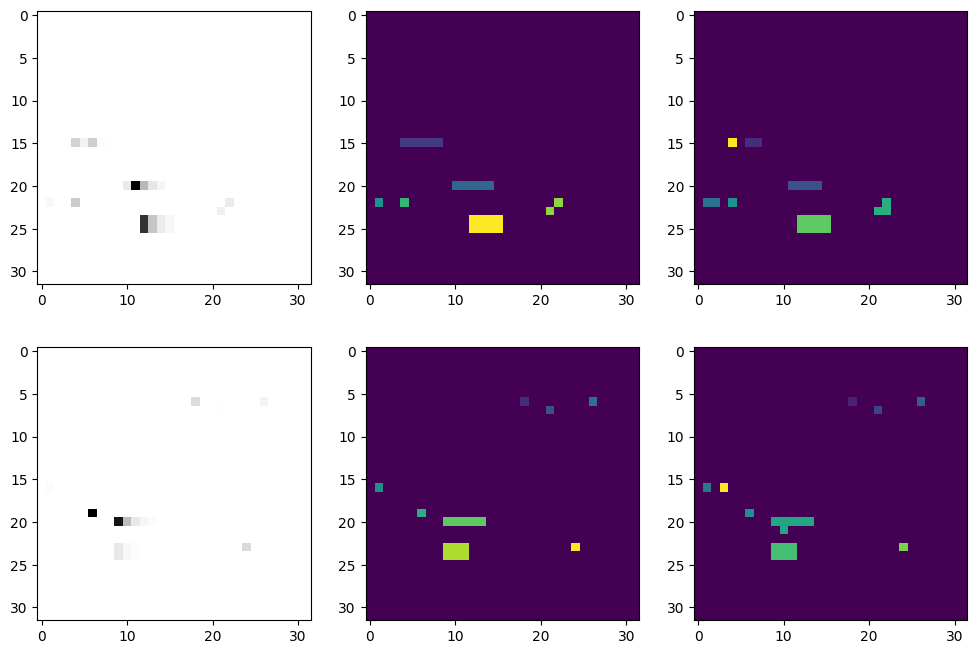

In [240]:
# DEBUG
num_example_to_display = 2
algo_sup_predicted_i = [6,11]
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for j in range(num_example_to_display):
    i = algo_sup_predicted_i[j]
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    lpred = mc_label_convert(lpred, lmc)
    
    axs[j][0].imshow(val_img[i])
    axs[j][1].imshow(lmc)
    axs[j][2].imshow(lpred)

## Weights Analysis

In [205]:
conv_layers = []
for layer in model.layers:
    if "conv" in layer.name:
        conv_layers.append(layer)

In [207]:
conv_layers[-1].weights

[<tf.Variable 'conv2d_10/kernel:0' shape=(3, 3, 4, 3) dtype=float32, numpy=
 array([[[[-1.4035053 , -0.1691594 ,  0.5675656 ],
          [-1.1871152 ,  0.7690637 , -0.31745037],
          [-0.2992162 ,  0.22094612,  0.28447524],
          [-0.7458423 , -0.04057514,  0.6524691 ]],
 
         [[-0.5535876 , -0.14646491, -0.2700452 ],
          [-0.52451366, -0.6197916 ,  0.2833118 ],
          [ 0.07278182,  0.12390114,  0.06175253],
          [-0.38205716,  0.5824628 , -0.4543049 ]],
 
         [[-0.76782376,  0.1783538 , -0.16027261],
          [-1.964151  , -0.17168693,  0.66626644],
          [-0.07286557,  0.03414439,  0.3442133 ],
          [-0.2962506 , -0.14498486,  0.21456781]]],
 
 
        [[[ 0.31782386,  0.46076563, -0.79639685],
          [-1.7392197 ,  1.157387  , -1.0183835 ],
          [ 0.2372554 ,  0.00982026, -0.05115276],
          [-0.6411901 ,  0.47011515, -0.55396944]],
 
         [[-0.7550947 ,  0.7621841 , -0.8723858 ],
          [-2.5892565 , -0.27853298,  1.37